# What is EDA?

Exploratory Data Analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. It's used to understand the data, uncover patterns, detect outliers and anomalies, and test hypotheses. EDA is a crucial step before formal modeling or hypothesis testing, as it helps in gaining insights into the data's structure and relationships.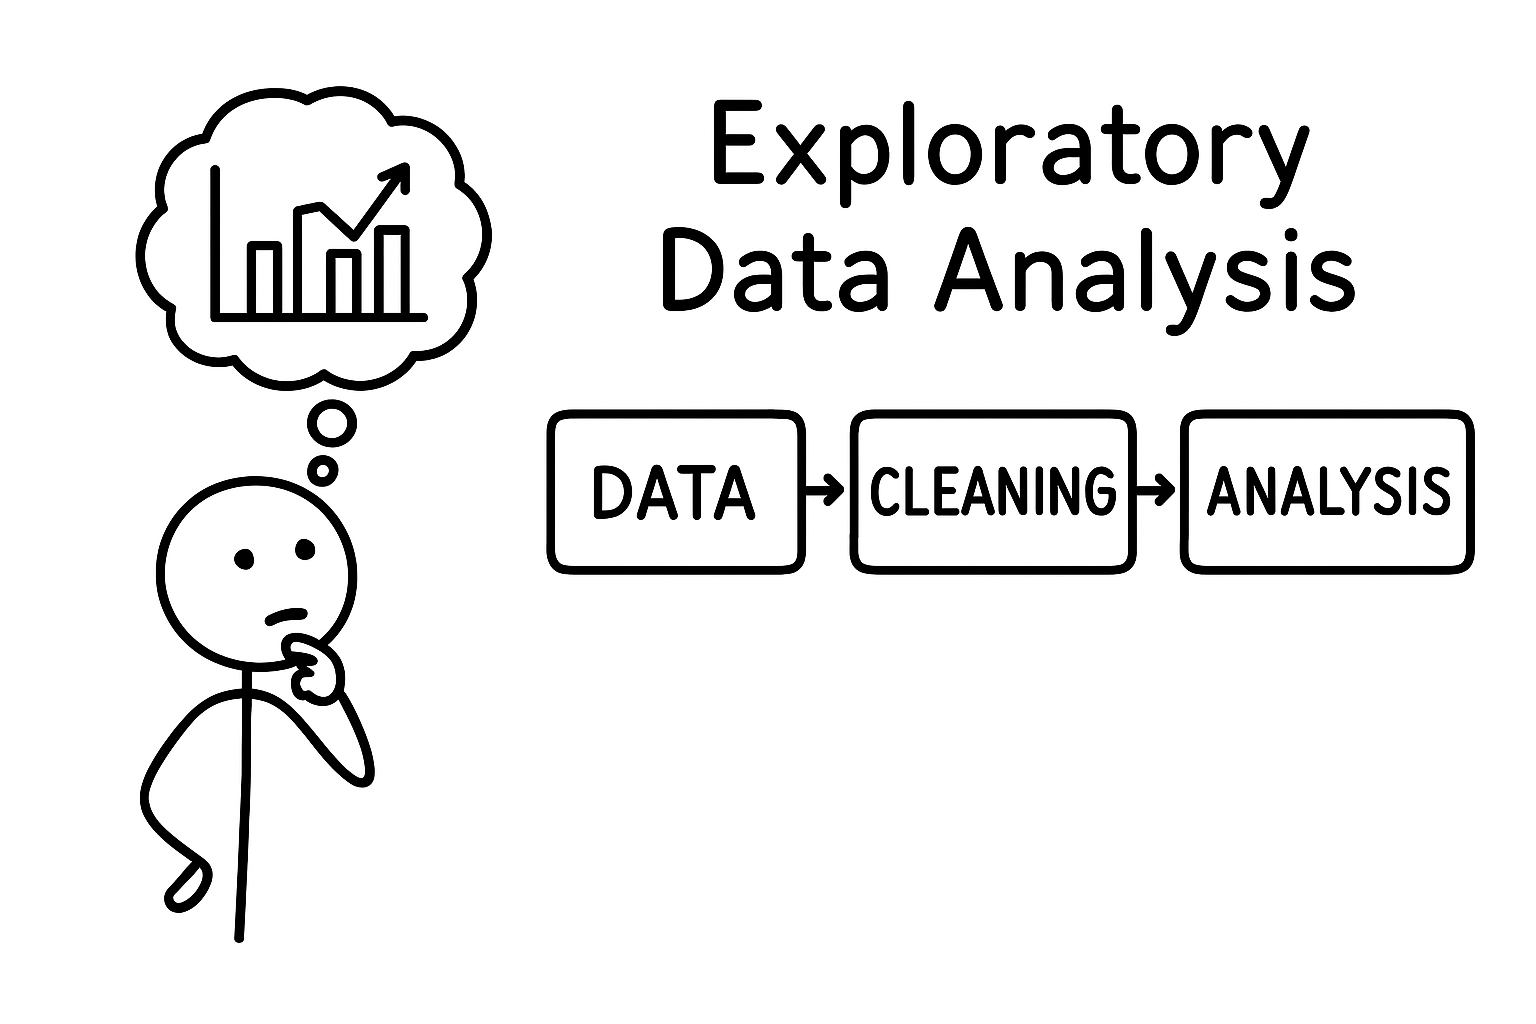

# What is SQL?

SQL (Structured Query Language) is a standard language for accessing and manipulating databases. It is used to communicate with databases, allowing you to manage data by performing tasks such as creating tables, inserting data, updating data, deleting data, and retrieving data. SQL is essential for working with relational databases and is widely used in data analysis, web development, and data science.

# Why SQL for EDA?
SQL is able to query for the exact data you want given constraints and filters, we can quickly select the specific data we need to make our insights without having to look through the entire dataset. Pandas is a Python library that also achieves this, basically a SQL abstraction.

# Getting Started

In [1]:
%pip install opendatasets

Defaulting to user installation because normal site-packages is not writeable

   ---------- ----------------------------- 1/4 [python-slugify]
   ---------- ----------------------------- 1/4 [python-slugify]
   -------------------- ------------------- 2/4 [kaggle]
   -------------------- ------------------- 2/4 [kaggle]
   -------------------- ------------------- 2/4 [kaggle]
   -------------------- ------------------- 2/4 [kaggle]
   -------------------- ------------------- 2/4 [kaggle]
   -------------------- ------------------- 2/4 [kaggle]
   -------------------- ------------------- 2/4 [kaggle]
   -------------------- ------------------- 2/4 [kaggle]
   -------------------- ------------------- 2/4 [kaggle]
   -------------------- ------------------- 2/4 [kaggle]
   -------------------- ------------------- 2/4 [kaggle]
   ------------------------------ --------- 3/4 [opendatasets]
   ------------------------------ --------- 3/4 [opendatasets]
   -----------------------------------

## Download and prepare the data

Download the dataset and prepare it for use with a SQL database.


**Reasoning**:
Download the dataset from Kaggle using the opendatasets library and examine the downloaded files.



In [2]:
import opendatasets as od
import os

dataset_url = 'https://www.kaggle.com/datasets/lykin22/tiktok-trending-data'
od.download(dataset_url)

# List the downloaded files
dataset_name = dataset_url.split('/')[-1]
download_path = f'./{dataset_name}'
print(f"Downloaded dataset to: {download_path}")
print("Files in the dataset:")
for root, dirs, files in os.walk(download_path):
    for file in files:
        print(os.path.join(root, file))

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: DataScience UCSB
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/lykin22/tiktok-trending-data


100%|██████████| 24.3k/24.3k [00:00<00:00, 46.3MB/s]


Downloaded dataset to: ./tiktok-trending-data
Files in the dataset:
./tiktok-trending-data/t.json
./tiktok-trending-data/m.json
./tiktok-trending-data/www.json


**Reasoning**:
The dataset contains JSON files. To prepare for a SQL database, I will read each JSON file into a pandas DataFrame and then save them as CSV files, which are generally easier to import into SQL databases.



In [9]:
json_files = [f for f in os.listdir(download_path) if f.endswith('.json')]

if json_files:
    first_json_file = os.path.join(download_path, json_files[0])
    print(f"Inspecting the first few lines of {first_json_file}:")
    with open(first_json_file, 'r', encoding='utf-8') as f:
        # Read and print the first 10 lines to get an idea of the structure
        for i in range(10):
            try:
                line = next(f)
                print(line.strip())
            except StopIteration:
                break
else:
    print("No JSON files found in the download directory.")

Inspecting the first few lines of ./tiktok-trending-data/t.json:
{
"user": [
{
"userId": "5831967",
"secUserId": "MS4wLjABAAAA-VASjiXTh7wDDyXvjk10VFhMWUAoxr8bgfO1kAL1-9s",
"id": "@charlidamelio",
"name": "charli d’amelio",
"bio": "",
"verified": true,
"avatar": {


**Reasoning**:
Iterate through the keys of the loaded JSON data, convert each list into a DataFrame, and save each DataFrame as a CSV file.



In [10]:
import json

output_csv_path = './tiktok_csv_data'
os.makedirs(output_csv_path, exist_ok=True)

json_files = [f for f in os.listdir(download_path) if f.endswith('.json')]

for json_file in json_files:
    json_filepath = os.path.join(download_path, json_file)
    print(f"Processing {json_filepath}...")

    try:
        with open(json_filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)

        for key, value in data.items():
            if isinstance(value, list):
                df = pd.DataFrame(value)
                csv_filename = f"{os.path.splitext(json_file)[0]}_{key}.csv"
                csv_filepath = os.path.join(output_csv_path, csv_filename)
                df.to_csv(csv_filepath, index=False)
                print(f"Saved {csv_filepath}")
            else:
                print(f"Skipping key '{key}' in {json_file} as it is not a list.")

    except Exception as e:
        print(f"Error processing {json_file}: {e}")

print(f"CSV files saved to {output_csv_path}")

Processing ./tiktok-trending-data/t.json...
Saved ./tiktok_csv_data/t_user.csv
Saved ./tiktok_csv_data/t_hashtag.csv
Saved ./tiktok_csv_data/t_music.csv
Processing ./tiktok-trending-data/m.json...
Saved ./tiktok_csv_data/m_user.csv
Saved ./tiktok_csv_data/m_hashtag.csv
Saved ./tiktok_csv_data/m_music.csv
Processing ./tiktok-trending-data/www.json...
Saved ./tiktok_csv_data/www_user.csv
Saved ./tiktok_csv_data/www_hashtag.csv
Saved ./tiktok_csv_data/www_music.csv
CSV files saved to ./tiktok_csv_data


## Set up a database environment

Set up a suitable environment to run SQL queries, like using a file-based SQL database (e.g., SQLite).


**Reasoning**:
Import the sqlite3 library and create a connection to a new SQLite database file, then create a cursor object.



In [11]:
import sqlite3

# Create a connection to the database
conn = sqlite3.connect('tiktok_trending.db')

# Create a cursor object
cursor = conn.cursor()

## Load the data into the database

### Subtask:
Load the prepared data into tables within the database.


**Reasoning**:
Iterate through the CSV files, read them into pandas DataFrames, and load them into the SQLite database as tables.



In [12]:
import glob
import os
import pandas as pd

csv_files = glob.glob('./tiktok_csv_data/*.csv')

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    table_name = os.path.splitext(os.path.basename(csv_file))[0]
    print(f"Loading {csv_file} into table {table_name}...")
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"Successfully loaded {table_name}")


Loading ./tiktok_csv_data/m_user.csv into table m_user...
Successfully loaded m_user
Loading ./tiktok_csv_data/www_music.csv into table www_music...
Successfully loaded www_music
Loading ./tiktok_csv_data/t_hashtag.csv into table t_hashtag...
Successfully loaded t_hashtag
Loading ./tiktok_csv_data/m_music.csv into table m_music...
Successfully loaded m_music
Loading ./tiktok_csv_data/www_hashtag.csv into table www_hashtag...
Successfully loaded www_hashtag
Loading ./tiktok_csv_data/m_hashtag.csv into table m_hashtag...
Successfully loaded m_hashtag
Loading ./tiktok_csv_data/t_user.csv into table t_user...
Successfully loaded t_user
Loading ./tiktok_csv_data/t_music.csv into table t_music...
Successfully loaded t_music
Loading ./tiktok_csv_data/www_user.csv into table www_user...
Successfully loaded www_user


## Perform data preprocessing with sql

### Subtask:
Use SQL queries to perform basic data cleaning and preprocessing steps.


**Reasoning**:
Inspect the schema of the tables in the database and identify columns for cleaning.



In [13]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';") # 1. Insert query here...
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    table_name = table[0]
    print(f"\nSchema for table: {table_name}")
    cursor.execute(f"PRAGMA table_info({table_name});")
    schema = cursor.fetchall()
    for col in schema:
        print(col)

Tables in the database:

Schema for table: m_user
(0, 'userId', 'INTEGER', 0, None, 0)
(1, 'secUserId', 'TEXT', 0, None, 0)
(2, 'id', 'TEXT', 0, None, 0)
(3, 'name', 'TEXT', 0, None, 0)
(4, 'bio', 'TEXT', 0, None, 0)
(5, 'verified', 'INTEGER', 0, None, 0)
(6, 'avatar', 'TEXT', 0, None, 0)
(7, 'stats', 'TEXT', 0, None, 0)

Schema for table: www_music
(0, 'musicId', 'INTEGER', 0, None, 0)
(1, 'avatar', 'TEXT', 0, None, 0)
(2, 'musicInfo', 'TEXT', 0, None, 0)
(3, 'stats', 'TEXT', 0, None, 0)

Schema for table: t_hashtag
(0, 'challengeId', 'INTEGER', 0, None, 0)
(1, 'description', 'TEXT', 0, None, 0)
(2, 'name', 'TEXT', 0, None, 0)
(3, 'avatar', 'TEXT', 0, None, 0)
(4, 'stats', 'TEXT', 0, None, 0)

Schema for table: m_music
(0, 'musicId', 'INTEGER', 0, None, 0)
(1, 'avatar', 'TEXT', 0, None, 0)
(2, 'musicInfo', 'TEXT', 0, None, 0)
(3, 'stats', 'TEXT', 0, None, 0)

Schema for table: www_hashtag
(0, 'challengeId', 'INTEGER', 0, None, 0)
(1, 'description', 'TEXT', 0, None, 0)
(2, 'name', 'TEX

**Reasoning**:
Check for missing values in columns of interest, particularly in the 'bio' and 'stats' columns in user tables, and 'description' and 'stats' in hashtag tables.



In [14]:
cursor.execute("SELECT COUNT(*) FROM t_user WHERE bio IS NULL OR bio = '';")
missing_bio_t_user = cursor.fetchone()[0]
print(f"Missing or empty 'bio' in t_user: {missing_bio_t_user}")

cursor.execute("SELECT COUNT(*) FROM t_user WHERE stats IS NULL OR stats = '';") # 2. Insert query here...
missing_stats_t_user = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM m_hashtag WHERE description IS NULL OR description = '';") # 3. Insert query here...
missing_desc_m_hashtag = cursor.fetchone()[0]
print(f"Missing or empty 'description' in m_hashtag: {missing_desc_m_hashtag}")

cursor.execute("SELECT COUNT(*) FROM m_hashtag WHERE stats IS NULL OR stats = '';")
missing_stats_m_hashtag = cursor.fetchone()[0]
print(f"Missing or empty 'stats' in m_hashtag: {missing_stats_m_hashtag}")

cursor.execute("SELECT COUNT(*) FROM m_music WHERE musicInfo IS NULL or musicInfo = '';") # 4. Insert query here...
missing_music_info_m_music = cursor.fetchone()[0]
print(f"Missing or empty 'musicInfo' in m_music: {missing_music_info_m_music}")

cursor.execute("SELECT COUNT(*) FROM m_music WHERE stats IS NULL OR stats = '';")
missing_stats_m_music = cursor.fetchone()[0]
print(f"Missing or empty 'stats' in m_music: {missing_stats_m_music}")

Missing or empty 'bio' in t_user: 2
Missing or empty 'description' in m_hashtag: 0
Missing or empty 'stats' in m_hashtag: 0
Missing or empty 'musicInfo' in m_music: 0
Missing or empty 'stats' in m_music: 0


**Reasoning**:
Extract data from the nested 'stats' column in the t_user table by treating the string as JSON and creating new columns for 'followers' and 'likes'.



In [18]:
import json
import ast

# Add new columns for followers and likes if they don't exist
cursor.execute("PRAGMA table_info(t_user);")
columns = [col[1] for col in cursor.fetchall()]

if 'followers' not in columns:
    cursor.execute("ALTER TABLE t_user ADD COLUMN followers INTEGER;")
    cursor.execute("ALTER TABLE t_user ADD COLUMN likes INTEGER;")
    conn.commit()

# Update the new columns by extracting data from the 'stats' column
cursor.execute("SELECT rowid, stats FROM t_user;")
rows = cursor.fetchall()

for row_id, stats_str in rows:
    if stats_str:
        try:
            # Use ast.literal_eval to safely parse the string as a Python literal
            stats_dict = ast.literal_eval(stats_str)
            followers = stats_dict.get('followers')
            likes = stats_dict.get('likes')
            cursor.execute("UPDATE t_user SET followers = ?, likes = ? WHERE rowid = ?", (followers, likes, row_id))
        except (ValueError, SyntaxError) as e:
            print(f"Could not parse stats string for rowid {row_id}: {stats_str} - Error: {e}")

conn.commit()

# Delete rows with missing or empty 'bio'
cursor.execute("DELETE FROM t_user WHERE bio IS NULL OR bio = '';")
conn.commit()

# Verify the update and deletion
print("\nVerifying extraction of followers and likes and deletion of rows with missing bio from t_user:")
cursor.execute("SELECT userId, stats, followers, likes, bio FROM t_user LIMIT 5;")
results = cursor.fetchall()
for row in results:
    print(row)

print("\nChecking for missing values in t_user table after cleaning:")
cursor.execute("SELECT COUNT(*) FROM t_user WHERE bio IS NULL OR bio = '';")
missing_bio_t_user_after = cursor.fetchone()[0]
print(f"Missing or empty 'bio' in t_user after cleaning: {missing_bio_t_user_after}")

cursor.execute("SELECT COUNT(*) FROM t_user WHERE stats IS NULL OR stats = '';")
missing_stats_t_user_after = cursor.fetchone()[0]
print(f"Missing or empty 'stats' in t_user after cleaning: {missing_stats_t_user_after}")


Verifying extraction of followers and likes and deletion of rows with missing bio from t_user:
(6748458643983238149, "{'followers': 76200000, 'likes': 1700000000}", 76200000, 1700000000, 'BUILD A BITCH MUSIC VIDEO OUT NOW😈')
(6727327145951183878, "{'followers': 58900000, 'likes': 370300000}", 58900000, 370300000, 'Same kid from West Philly.')
(6957597538883142661, "{'followers': 11100000, 'likes': 173300000}", 11100000, 173300000, 'LIGHTS ARE OFF\nI bring nightmares to life every night 💀\n3D Animator')
(6780564068844880902, "{'followers': 26300000, 'likes': 362700000}", 26300000, 362700000, 'Immigrant 🇱🇧 Not Malala. Inquiries@Myotis.co')
(6746417382892176389, "{'followers': 19400000, 'likes': 817500000}", 19400000, 817500000, 'DM’ing new followers on IG right now 😍↖️')

Checking for missing values in t_user table after cleaning:
Missing or empty 'bio' in t_user after cleaning: 0
Missing or empty 'stats' in t_user after cleaning: 0


## Perform exploratory data analysis with sql

### Subtask:
Use SQL queries to explore the data, calculate statistics, and identify patterns.


**Reasoning**:
Execute SQL queries to calculate and display the average number of followers and likes for users in the t_user table.



In [19]:
cursor.execute("SELECT AVG(followers), AVG(likes) FROM t_user;") # 5. Insert query here...
avg_stats = cursor.fetchone()
print(f"Average Followers: {avg_stats[0]:,.2f}")
print(f"Average Likes: {avg_stats[1]:,.2f}")

Average Followers: 23,637,037.04
Average Likes: 812,281,481.48


**Reasoning**:
Execute a SQL query to find and display the top 10 users with the most followers from the `t_user` table.



In [21]:
print("\nTop 10 users by followers:")
cursor.execute("SELECT name, followers FROM t_user ORDER BY followers DESC LIMIT 10;")
top_followers = cursor.fetchall()
for user in top_followers:
    print(f"User: {user[0]}, Followers: {user[1]:,}")


Top 10 users by followers:
User: Bella Poarch, Followers: 76,200,000
User: Zach King, Followers: 62,400,000
User: Will Smith, Followers: 58,900,000
User: Loren Gray, Followers: 53,300,000
User: avani, Followers: 35,200,000
User: Joe, Followers: 32,600,000
User: BILLIE EILISH, Followers: 32,300,000
User: noah beck, Followers: 29,100,000
User: Mia Khalifa, Followers: 26,300,000
User: KEEMOKAZI, Followers: 19,400,000


**Reasoning**:
Execute a SQL query to find and display the top 10 users with the most likes from the `t_user` table, count the number of verified and unverified users, and calculate the average followers and likes for verified vs. unverified users.



In [22]:
print("\nTop 10 users by likes:")
cursor.execute("SELECT name, likes from t_user ORDER BY likes DESC LIMIT 10;") # 6. Insert query here...
top_likes = cursor.fetchall()
for user in top_likes:
    print(f"User: {user[0]}, Likes: {user[1]:,}")

print("\nNumber of verified and unverified users:")
cursor.execute("SELECT verified, COUNT(*) FROM t_user GROUP BY verified;")
verification_counts = cursor.fetchall()
for count in verification_counts:
    status = "Verified" if count[0] == 1 else "Unverified"
    print(f"{status}: {count[1]}")

print("\nAverage followers and likes for verified vs. unverified users:")
cursor.execute("SELECT verified, AVG(followers), AVG(likes) from t_user GROUP by verified;") # 7. Insert query here...
avg_stats_by_verification = cursor.fetchall()
for stats in avg_stats_by_verification:
    status = "Verified" if stats[0] == 1 else "Unverified"
    print(f"{status} - Average Followers: {stats[1]:,.2f}, Average Likes: {stats[2]:,.2f}")


Top 10 users by likes:
User: Loren Gray, Likes: 2,800,000,000
User: avani, Likes: 2,500,000,000
User: noah beck, Likes: 1,800,000,000
User: Bella Poarch, Likes: 1,700,000,000
User: ESPN, Likes: 1,200,000,000
User: Joe, Likes: 1,200,000,000
User: Overtime, Likes: 1,200,000,000
User: Brooke Monk, Likes: 1,200,000,000
User: anna x, Likes: 849,900,000
User: KEEMOKAZI, Likes: 817,500,000

Number of verified and unverified users:
Unverified: 5
Verified: 22

Average followers and likes for verified vs. unverified users:
Unverified - Average Followers: 9,740,000.00, Average Likes: 301,140,000.00
Verified - Average Followers: 26,795,454.55, Average Likes: 928,450,000.00


## Summary:

### Data Analysis Key Findings

*   The average number of followers for users in the `t_user` table is approximately 23.64 million, while the average number of likes is approximately 812.28 million.
*   The top 10 users by followers and likes were identified, showing high engagement metrics for leading accounts.
*   There are significantly more verified users (22) than unverified users (5) in the `t_user` table.
*   Verified users, on average, have considerably more followers (approx. 26.8 million) and likes (approx. 928.45 million) compared to unverified users (approx. 9.74 million followers and 301.14 million likes).

### Insights or Next Steps

*   The substantial difference in average followers and likes between verified and unverified users suggests that verification status on TikTok might be strongly correlated with user popularity and engagement metrics.
*   Further analysis could involve joining tables (e.g., users with their music or hashtags) to explore relationships between content, users, and popularity, or examining trends over time if temporal data were available.


### Take Home Task

Find another TikTok dataset from Kaggle (or scraping if you're more advanced) and use the similar SQL queries and the same EDA process to analyze an interesting trend in the dataset. Use aggregate statements, joins, and filtering techniques in your queries for more practice.

## Answers
1. "SELECT name FROM sqlite_master WHERE type='table';"
2. "SELECT COUNT(*) FROM t_user WHERE stats IS NULL OR stats = '';"
3. "SELECT COUNT(*) FROM m_hashtag WHERE description IS NULL OR description = '';"
4. "SELECT COUNT(*) FROM m_music WHERE musicInfo IS NULL OR musicInfo = '';"
5. "SELECT AVG(followers), AVG(likes) FROM t_user;"
6. "SELECT name, likes FROM t_user ORDER BY likes DESC LIMIT 10;"
7. "SELECT verified, AVG(followers), AVG(likes) FROM t_user GROUP BY verified;"